# 2.1 Getting your data + feature engineering

Sometimes, the features (variables, fields) are not given in a dataset but can be created from it. The previous step is known as feature engineering. For example, the original dataset has several transactions done by the same customer. Then, we suggest you to group data by the client (using CustomerId) and, based on it, create the following new features for each CustomerId:

In [333]:
import pandas as pd
import numpy as np
from datetime import datetime

In [334]:
df = pd.read_csv('F:/Sapienza/ADM/bank_transactions.csv')

In [335]:
df

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.0
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0


In [336]:
df.dropna(inplace=True)

In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041614 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1041614 non-null  object 
 1   CustomerID               1041614 non-null  object 
 2   CustomerDOB              1041614 non-null  object 
 3   CustGender               1041614 non-null  object 
 4   CustLocation             1041614 non-null  object 
 5   CustAccountBalance       1041614 non-null  float64
 6   TransactionDate          1041614 non-null  object 
 7   TransactionTime          1041614 non-null  int64  
 8   TransactionAmount (INR)  1041614 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 79.5+ MB


In [338]:
#Converting the data type of CustomerDOB,TransactionDate, TransactionTime
df.CustomerDOB = pd.to_datetime(df.CustomerDOB) 
df.TransactionDate = pd.to_datetime(df.TransactionDate)
df.TransactionTime = df.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S').time())

#### a)Number of transactions for each customer id

In [341]:
df['TransactionNO'] = df['TransactionID'].groupby(df['CustomerID']).transform('count')

#### b) Number of transactions with a balance bigger than 100 USD 

In [344]:
#Convert INR to USD for each transaction:  1 USD = 81.6 INR 
df['TransactionAmount(USD)'] = (df['TransactionAmount (INR)']/81.6 ).astype('int')

In [345]:
#The "Above100USD" equsals to 1 if transaction amount is more than 100 USD, otherwise 0  
df.loc[df['TransactionAmount(USD)'] >= 100, 'Above100USD'] = 1 
df.loc[df['TransactionAmount(USD)'] < 100, 'Above100USD'] = 0 
df.Above100USD = df.Above100USD.astype('int')

In [346]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041614 entries, 0 to 1048566
Data columns (total 12 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   TransactionID            1041614 non-null  object        
 1   CustomerID               1041614 non-null  object        
 2   CustomerDOB              1041614 non-null  datetime64[ns]
 3   CustGender               1041614 non-null  object        
 4   CustLocation             1041614 non-null  object        
 5   CustAccountBalance       1041614 non-null  float64       
 6   TransactionDate          1041614 non-null  datetime64[ns]
 7   TransactionTime          1041614 non-null  object        
 8   TransactionAmount (INR)  1041614 non-null  float64       
 9   TransactionNO            1041614 non-null  int64         
 10  TransactionAmount(USD)   1041614 non-null  int32         
 11  Above100USD              1041614 non-null  int32         
dtype

In [372]:
# the number of above 100 USD transaction that ecah customer had 
df['Above100Count'] = df['Above100USD'].groupby(df['CustomerID']).transform('sum')

#### c) Average amount of the transactions

In [347]:
# based on the Transaction Amount in USD
df['TransactionAverage'] = df['TransactionAmount(USD)'].groupby(df['CustomerID']).transform('mean')

####  d)Average balance (in USD)

In [349]:
df['CustAccountBalance(USD)'] = df['CustAccountBalance'] / 81.6 
df['BalanceAverage'] = df['CustAccountBalance(USD)'].groupby(df['CustomerID']).transform('mean').round(1)

#### e) Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation).

In [350]:
df['Utilisation'] = df['BalanceAverage'] - df['TransactionAverage']

#### f) Most common gender of the customer

In [351]:
df.CustGender.unique()

array(['F', 'M', 'T'], dtype=object)

In [352]:
# Create columns to calculate the frequency of each gender F,M,T
df.loc[df['CustGender'] == 'F', 'FFreq' ] =  1
df.loc[df['CustGender'] != 'F', 'FFreq' ] =  0
df.loc[df['CustGender'] == 'T', 'TFreq' ] =  1
df.loc[df['CustGender'] != 'T', 'TFreq' ] =  0
df.loc[df['CustGender'] == 'M', 'MFreq' ] =  1
df.loc[df['CustGender'] != 'M', 'MFreq' ] =  0
 
df.FFreq  = df.FFreq.astype('int') 
df.TFreq  = df.TFreq.astype('int')
df.MFreq  = df.MFreq.astype('int')

In [353]:
# define the proportion of being F, M, T for each CustomerID
df['Fper'] = df.FFreq.groupby(df['CustomerID']).transform('sum') / df.TransactionNO.groupby(df['CustomerID']).transform('count')
df['Mper'] = df.MFreq.groupby(df['CustomerID']).transform('sum') / df.TransactionNO.groupby(df['CustomerID']).transform('count')
df['Tper'] = df.TFreq.groupby(df['CustomerID']).transform('sum') / df.TransactionNO.groupby(df['CustomerID']).transform('count')

In [354]:
df.sort_values(by = 'CustomerID').head(10)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionNO,...,TransactionAverage,CustAccountBalance(USD),BalanceAverage,Utilisation,FFreq,TFreq,MFreq,Fper,Mper,Tper
33670,T33671,C1010011,1992-08-19,F,NOIDA,32500.73,2016-09-26,12:38:13,4750.0,2,...,31.0,398.293260,935.5,904.5,1,0,0,0.5,0.5,0.0
173508,T173509,C1010011,1983-05-08,M,NEW DELHI,120180.54,2016-09-08,01:12:29,356.0,2,...,31.0,1472.800735,935.5,904.5,0,0,1,0.5,0.5,0.0
363021,T363022,C1010012,1994-07-28,M,MUMBAI,24204.49,2016-08-14,20:44:09,1499.0,1,...,18.0,296.623652,296.6,278.6,0,0,1,0.0,1.0,0.0
251647,T251648,C1010014,1984-08-19,M,MUMBAI,161848.76,2016-07-08,22:03:05,250.0,2,...,8.5,1983.440686,1226.9,1218.4,0,0,1,0.5,0.5,0.0
89543,T89544,C1010014,1992-04-06,F,MUMBAI,38377.14,2016-01-08,15:44:51,1205.0,2,...,8.5,470.308088,1226.9,1218.4,1,0,0,0.5,0.5,0.0
971993,T971994,C1010018,1990-05-29,F,CHAMPARAN,496.18,2016-09-15,17:02:54,30.0,1,...,0.0,6.080637,6.1,6.1,1,0,0,1.0,0.0,0.0
401395,T401396,C1010024,2065-06-21,M,KOLKATA,87058.65,2016-08-18,14:11:03,5000.0,1,...,61.0,1066.895221,1066.9,1005.9,0,0,1,0.0,1.0,0.0
642231,T642232,C1010028,1988-08-25,F,DELHI,296828.37,2016-08-29,09:52:12,557.0,1,...,6.0,3637.602574,3637.6,3631.6,1,0,0,1.0,0.0,0.0
169854,T169855,C1010031,1988-09-06,M,TRICHY,8646.21,2016-04-08,21:23:14,1460.0,2,...,10.5,105.958456,63.7,53.2,0,0,1,0.0,1.0,0.0
50880,T50881,C1010031,1984-07-21,M,VAPI,1754.10,2016-03-08,11:32:29,404.0,2,...,10.5,21.496324,63.7,53.2,0,0,1,0.0,1.0,0.0


In [355]:
#if the frequency of transaction per each gender is the same:
df['MF'] = df.apply(lambda x: 1 if x['Mper'] == x['Fper'] == 0.5  else 0, axis=1)
df['MT'] = df.apply(lambda x: 1 if x['Mper'] == x['Tper'] == 0.5  else 0, axis=1)
df['FT'] = df.apply(lambda x: 1 if x['Tper'] == x['Fper'] == 0.5  else 0, axis=1) 

In [356]:
#Else:
df['IsM'] = df.apply(lambda x: 1 if (x['MF'] == 0 and x['MT'] == 0 and x['MFreq'] > 0) else 0, axis=1)
df['IsF'] = df.apply(lambda x: 1 if (x['MF'] == 0 and x['FT'] == 0 and x['FFreq'] > 0) else 0, axis=1)
df['IsT'] = df.apply(lambda x: 1 if (x['FT'] == 0 and x['MT'] == 0 and x['TFreq'] > 0) else 0, axis=1)

In [357]:
def CommonGender(row):
    if row['IsM'] == 1:
        return 'M'
    elif row['IsF'] == 1:
        return 'F'
    elif row['IsT'] == 1:
        return 'T'
    elif row['FT'] == 1:
        return 'FT'
    elif row['MT'] == 1:
        return 'MT'    
    else:
        return 'MF'

In [358]:
df['CommonGender'] = df.apply(CommonGender, axis=1)

Consider at least 20 additional features that can be generated for each CustomerId. Describe each of them and why you believe they will be helpful. Moreover, add it to the previous dataset (the one with seven features). In the end, you should have for each CustomerID at least 27 features (7 recommended + 20 suggested by you).

In [360]:
df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

In [361]:
# define a column to calculate Customer age per each TransactionID; Each CustomerID may have 2 or more different Date of Birth
df['CustomerAge'] = (( pd.to_datetime('today') - df.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
df['CustomerAge'] = df['CustomerAge'].astype(int)

In [363]:
#Define a column to measure the average age of a CustomerID
df['CustAveAge'] = df['CustomerAge'].groupby(df['CustomerID']).transform('mean')
df['CustAveAge'].astype('int')

0          28
1          66
2          26
3          46
4          35
           ..
1048562    32
1048563    31
1048564    43
1048565    44
1048566    35
Name: CustAveAge, Length: 1041614, dtype: int32

In [364]:
# in order to define the most recent transaction of customers 
df['TranasctionDateDiff'] = (( pd.to_datetime('today') - df.TransactionDate ) / np.timedelta64(1, 'D')).round(1)
df['RecentTDateDiff'] = df['TranasctionDateDiff'].groupby(df['CustomerID']).transform('min')

In [365]:
#Minimum amount of each customer balance
df['MinBalance'] = df['CustAccountBalance(USD)'].groupby(df['CustomerID']).transform('min').round(1)

In [366]:
#Maximum amount of each customer balance
df['MaxBalance'] = df['CustAccountBalance(USD)'].groupby(df['CustomerID']).transform('max').round(1)

In [367]:
#The First transaction for each CustomerID
df['FirstTran'] = df['TransactionDate'].groupby(df['CustomerID']).transform('min')

In [368]:
#The last transaction for each CustomerID
df['LastTran'] = df['TransactionDate'].groupby(df['CustomerID']).transform('max')

In [369]:
# To measure howlong does a CustomerID use the account
df['CustLifetime'] = (df['LastTran'] - df['FirstTran'])

In [370]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041614 entries, 0 to 1048566
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype          
---  ------                   --------------    -----          
 0   TransactionID            1041614 non-null  object         
 1   CustomerID               1041614 non-null  object         
 2   CustomerDOB              1041614 non-null  datetime64[ns] 
 3   CustGender               1041614 non-null  object         
 4   CustLocation             1041614 non-null  object         
 5   CustAccountBalance       1041614 non-null  float64        
 6   TransactionDate          1041614 non-null  datetime64[ns] 
 7   TransactionTime          1041614 non-null  object         
 8   TransactionAmount (INR)  1041614 non-null  float64        
 9   TransactionNO            1041614 non-null  int64          
 10  TransactionAmount(USD)   1041614 non-null  int32          
 11  Above100USD              1041614 non-null  int32  

In [373]:
df[['CustomerID','CustGender','TransactionNO','TransactionAmount(USD)','Above100USD','Above100Count','TransactionAverage', 'BalanceAverage','Utilisation','TranasctionDateDiff','CommonGender','CustAveAge','MinBalance','MaxBalance','FirstTran','LastTran','CustLifetime']].sort_values(by = 'CustomerID').head(10)

,CustomerID,CustGender,TransactionNO,TransactionAmount(USD),Above100USD,Above100Count,TransactionAverage,BalanceAverage,Utilisation,TranasctionDateDiff,CommonGender,CustAveAge,MinBalance,MaxBalance,FirstTran,LastTran,CustLifetime
33670,C1010011,F,2,58,0,0,31.0,935.5,904.5,2268.0,MF,35.0,398.3,1472.8,2016-09-08,2016-09-26,18 days
173508,C1010011,M,2,4,0,0,31.0,935.5,904.5,2286.0,MF,35.0,398.3,1472.8,2016-09-08,2016-09-26,18 days
363021,C1010012,M,1,18,0,0,18.0,296.6,278.6,2311.0,M,28.0,296.6,296.6,2016-08-14,2016-08-14,0 days
251647,C1010014,M,2,3,0,0,8.5,1226.9,1218.4,2348.0,MF,34.5,470.3,1983.4,2016-01-08,2016-07-08,182 days
89543,C1010014,F,2,14,0,0,8.5,1226.9,1218.4,2530.0,MF,34.5,470.3,1983.4,2016-01-08,2016-07-08,182 days
971993,C1010018,F,1,0,0,0,0.0,6.1,6.1,2279.0,F,33.0,6.1,6.1,2016-09-15,2016-09-15,0 days
401395,C1010024,M,1,61,0,0,61.0,1066.9,1005.9,2307.0,M,57.0,1066.9,1066.9,2016-08-18,2016-08-18,0 days
642231,C1010028,F,1,6,0,0,6.0,3637.6,3631.6,2296.0,F,34.0,3637.6,3637.6,2016-08-29,2016-08-29,0 days
169854,C1010031,M,2,17,0,0,10.5,63.7,53.2,2439.0,M,36.0,21.5,106.0,2016-03-08,2016-04-08,31 days
50880,C1010031,M,2,4,0,0,10.5,63.7,53.2,2470.0,M,36.0,21.5,106.0,2016-03-08,2016-04-08,31 days


In [375]:
# Create new dataframe included essential columns
df_new = df[['CustomerID','TransactionNO', 'TransactionAmount(USD)', 'Above100USD', 'Above100Count','TransactionAverage','CommonGender', 'CustAveAge','RecentTDateDiff','MinBalance','MaxBalance','FirstTran','LastTran','CustLifetime']].copy()

In [377]:
df_new = df_new.drop_duplicates(subset='CustomerID', keep = "last")

In [378]:
df_new

,CustomerID,TransactionNO,TransactionAmount(USD),Above100USD,Above100Count,TransactionAverage,CommonGender,CustAveAge,RecentTDateDiff,MinBalance,MaxBalance,FirstTran,LastTran,CustLifetime
0,C5841053,1,0,0,0,0.0,F,28.0,2499.0,218.4,218.4,2016-02-08,2016-02-08,0 days
1,C2142763,1,343,1,1,343.0,M,66.0,2499.0,27.8,27.8,2016-02-08,2016-02-08,0 days
2,C4417068,1,5,0,0,5.0,F,26.0,2499.0,219.0,219.0,2016-02-08,2016-02-08,0 days
4,C9031234,1,21,0,0,21.0,F,35.0,2499.0,82.3,82.3,2016-02-08,2016-02-08,0 days
5,C1536588,1,8,0,0,8.0,F,50.0,2499.0,657.0,657.0,2016-02-08,2016-02-08,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,C8020229,1,9,0,0,9.0,M,32.0,2276.0,93.6,93.6,2016-09-18,2016-09-18,0 days
1048563,C6459278,1,5,0,0,5.0,M,31.0,2276.0,334.7,334.7,2016-09-18,2016-09-18,0 days
1048564,C6412354,2,9,0,0,5.5,M,43.5,2276.0,45.1,2717.6,2016-09-15,2016-09-18,3 days
1048565,C6420483,1,12,0,0,12.0,M,44.0,2276.0,124.0,124.0,2016-09-18,2016-09-18,0 days


In [379]:
df_new = df_new.set_index('CustomerID')

In [380]:
df_new.sort_values(by = 'CustomerID').head()

,TransactionNO,TransactionAmount(USD),Above100USD,Above100Count,TransactionAverage,CommonGender,CustAveAge,RecentTDateDiff,MinBalance,MaxBalance,FirstTran,LastTran,CustLifetime
CustomerID,,,,,,,,,,,,,
C1010011,2,4,0,0,31.0,MF,35.0,2268.0,398.3,1472.8,2016-09-08,2016-09-26,18 days
C1010012,1,18,0,0,18.0,M,28.0,2311.0,296.6,296.6,2016-08-14,2016-08-14,0 days
C1010014,2,3,0,0,8.5,MF,34.5,2348.0,470.3,1983.4,2016-01-08,2016-07-08,182 days
C1010018,1,0,0,0,0.0,F,33.0,2279.0,6.1,6.1,2016-09-15,2016-09-15,0 days
C1010024,1,61,0,0,61.0,M,57.0,2307.0,1066.9,1066.9,2016-08-18,2016-08-18,0 days


# 2.2 Choose your features (variables)!

1) To normalise or not to normalise? That's the question. Sometimes it is worth normalising (scaling) the features. Explain if it is a good idea to perform any normalisation method. If you think the normalisation should be used, apply it to your data (look at the available normalisation functions in the scikit-learn library).

In [214]:
from sklearn.preprocessing import MinMaxScaler

In [325]:
X = np.array(df_new['TransactionAverage']).reshape(-1,1)
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
df_new['min_max'] = X_scaled.reshape(1,-1)[0]

In [326]:
df_new['min_max'] 

CustomerID
C5841053    0.000000
C2142763    0.017941
C4417068    0.000262
C9031234    0.001098
C1536588    0.000418
              ...   
C8020229    0.000471
C6459278    0.000262
C6412354    0.000288
C6420483    0.000628
C8337524    0.000445
Name: min_max, Length: 879358, dtype: float64

In [320]:
from sklearn.preprocessing import StandardScaler

In [329]:
Y = np.array(df_new['TransactionAverage']).reshape(-1,1)
scaler = StandardScaler()
scaler.fit(Y)
Y_scaled = scaler.transform(X)
df_new['zScore'] = Y_scaled.reshape(1,-1)[0]

In [330]:
df_new['zScore']

CustomerID
C5841053   -0.237689
C2142763    4.113247
C4417068   -0.174264
C9031234    0.028695
C1536588   -0.136209
              ...   
C8020229   -0.123524
C6459278   -0.174264
C6412354   -0.167922
C6420483   -0.085469
C8337524   -0.129867
Name: zScore, Length: 879358, dtype: float64

In [324]:
import matplotlib.pyplot as plt

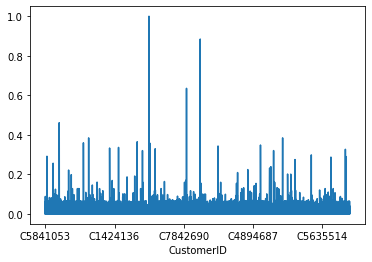

In [327]:
df_new['min_max'].plot()
plt.show()

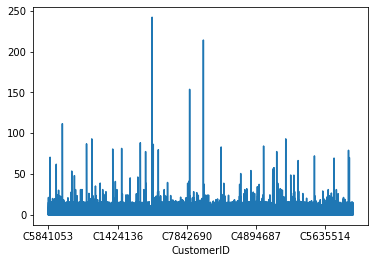

In [332]:
df_new['zScore'].plot()
plt.show()